In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statistics import mean, stdev
import sys
import os
if "../" not in sys.path:
  sys.path.append("../") 
os.chdir("..") 
from envs.data_handler import DataHandler
import envs.data_utils as du

dh = DataHandler(data_generation='Linear', take_component_id=True, transformation='raw')
dh.data.head()

,Optimal_Affected_Component_Uid,Optimal_Failure,raw
0,_SEwwu-cdEeet0YmmfbMwkw,CF1,49.5
1,_SExXgOcdEeet0YmmfbMwkw,CF2,16.0
2,_SEx_HucdEeet0YmmfbMwkw,CF3,31.5
3,_SEymDucdEeet0YmmfbMwkw,CF3,25.0
4,_SExYKucdEeet0YmmfbMwkw,CF3,16.0


# Data Shift

Step 1: Calculate the Standard Deviation

In [2]:
stdev_values = dh.data.groupby([dh.data.columns[0], dh.data.columns[1]]).std().reset_index().fillna(0)
stdev_values.head()

,Optimal_Affected_Component_Uid,Optimal_Failure,raw
0,_SE-L2-cdEeet0YmmfbMwkw,CF1,0.0
1,_SE-L4ucdEeet0YmmfbMwkw,CF1,0.0
2,_SE-L5ecdEeet0YmmfbMwkw,CF1,0.0
3,_SE-L8ecdEeet0YmmfbMwkw,CF3,0.0
4,_SE-L_ecdEeet0YmmfbMwkw,CF1,0.0


Step 2: Calculate the mean of each <component, failure> combinations and sort them ascending

In [3]:
ordering1 = du.get_ordering(dh.data)
ordering1.head()

,Optimal_Affected_Component_Uid,Optimal_Failure,raw
698,_SFLoA-cdEeet0YmmfbMwkw,CF2,5.0
109,_SE7IwecdEeet0YmmfbMwkw,CF1,5.0
493,_SFFhMOcdEeet0YmmfbMwkw,CF3,5.0
437,_SFE5-OcdEeet0YmmfbMwkw,CF3,5.0
661,_SFLB7-cdEeet0YmmfbMwkw,CF3,5.0


Step 3: Iterate over data and shift it

In [4]:
data_new = du.shift_data(dh.data)  
data_new.head()

,Optimal_Affected_Component_Uid,Optimal_Failure,raw
0,_SEwwu-cdEeet0YmmfbMwkw,CF1,60.295935
1,_SExXgOcdEeet0YmmfbMwkw,CF2,16.000000
2,_SEx_HucdEeet0YmmfbMwkw,CF3,31.500000
3,_SEymDucdEeet0YmmfbMwkw,CF3,25.000000
4,_SExYKucdEeet0YmmfbMwkw,CF3,16.000000


## Step 4: Analyse

## Step 5: Perform T-Test

In [5]:
result = du.perform_ttest(data_new)
num_significant_pairs = len(result[result['pvalue']<0.025])
total = len(result.index)
print('{0} of the {1} <component, failure> combination pairs are statistical significant'.format(num_significant_pairs, total))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3505: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


13 of the 914 <component, failure> combination pairs are statistical significant


# Parameterization

Evaluate different spread mulitplication factors for an optimal shifting for each of the transformed datasets (e.g. cube/square root transfromation):

\begin{align}
x_{new} = x_{old} + f * (\sigma(x_{-1}) + \sigma(x))
\end{align}

where $x_{old}$ is the original value from a certain dataset related to <component,failure> and needs to be shifted. Here, we evaluate different values for $f \in \mathbb{N}^{+}$ as the spread mulitplication factor which is mulitplied with the standard deviation of the previous <component,failure> combination $\sigma(x_{-1})$ and of the current one $\sigma(x)$. 

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3505: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'raw': (117, 35), 'cube': (688, 167), 'sqt': (553, 158), 'log10': (630, 164), 'ln': (882, 170), 'log2': (375, 137)}


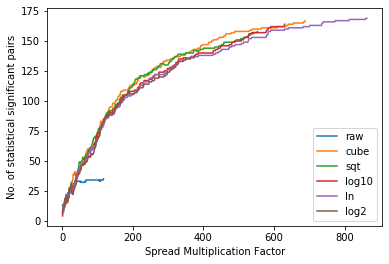

In [2]:
result = {}

trans = ['raw', 'cube', 'sqt', 'log10', 'ln', 'log2']
factor = range(1, 914, 1)

for t in trans:
    X = []
    Y = []
    stop = 50
    
    # load the data 
    dh = DataHandler(data_generation='Linear', take_component_id=True, transformation=t)
    
    # initialize the result dictionary for each transformation
    if t not in result:
        result[t] = (0,0) # (spread_multiplication_factor, number of statistical significant pairs) 
    
    # evaluate the different spread mulitplication factors
    for f in factor:
        
        '''
        If after 50 rounds no increase of the number of statistical significant pairs has been detected,
        we finish the evaluation for a type of transformed data.
        '''
        if stop != 0:
            
            shifted_data = du.shift_data(dh.data, spread_multiplication_factor=f)
            ttest = du.perform_ttest(shifted_data)
            num_significant_pairs = len(ttest[ttest['pvalue']<0.025])
            
            # save the results for plotting
            X.append(f) # factor
            Y.append(num_significant_pairs) # number of statistical significant pairs
            
            if num_significant_pairs > result[t][1]:
                # we were able to generate at least one more statistical significant pair
                result[t] = (f, num_significant_pairs)
                stop = 50
            else:
                # less or the same number of satistical significant pairs
                stop -= 1
                
            print("{0}: With the spread multiplication factor of {1} we have {2} statistical significant pairs. (Stop in {3})".format(t, f, num_significant_pairs, stop), end="\r")
            
        else:
            break
    
    plt.plot(X[:len(X)-50], Y[:len(Y)-50], label=t)


print(result)
plt.xlabel("Spread Multiplication Factor")
plt.ylabel("No. of statistical significant pairs")
plt.legend()
plt.savefig('data_analysis/shifting_parameter_evaluation.pdf') 
plt.show()

And then saving optimal shifted data to csv

In [2]:
result = {'raw': (117, 35), 'cube': (688, 167), 'sqt': (553, 158), 'log10': (630, 164), 'ln': (882, 170), 'log2': (375, 137)}
dh = DataHandler(data_generation='Linear', take_component_id=True, transformation='raw')
optimal_shifted_data = dh.data[[dh.data.columns[0], dh.data.columns[1]]]

for t, value in result.items():
    dh = DataHandler(data_generation='Linear', take_component_id=True, transformation=t)
    data = du.shift_data(dh.data, spread_multiplication_factor=value[0])
    optimal_shifted_data = optimal_shifted_data.merge(data[dh.data.columns[2]], how='outer', left_index=True, right_index=True)
    
optimal_shifted_data.to_csv('data/prepared_data/LinearShifted_Id.csv')
print("Data saved.")

Data saved.
